In [1]:
import numpy as np
import matplotlib.pyplot as plt

Kalman filter is an algorithm to predict state of the a dynamic system from initial state and noisy measurements. For object tracking, initial state would be object location, velocity of objects in first frame, noisy measurements are location of objects in following frames. We will present it following format: Concept, Math and Code

Kalman filter have 2 steps: prediction and update   


**Predictions**   
In this step, algorithm will predict next state of system based on current state. Each state would be presented as a vector and the covariance of it. Because 

**Update**  
In this step, algorigthm get the new measurement and "update" predictions. 


## Math
In SORT, state of an object is an vector includes its location and velocity.  $x = [cx, cy, s, r, \dot cx, \dot cy, \dot s, \dot r]$. Where  
- $cx, cy$: center coordinates of the bounding box
- $s$: the area of the bounding box
- $r$: the ration of width/height
- $\dot cx, \dot cy, \dot s, \dot r$: velocity (rate of change) of above components

We would use following notation for the rest of post
- $x_{t} \in R^{n}$: state vector at timestep $t$
- $z_{t} \in R^{m}$: measurement vector at timestep $t$. In our case, it would be location of bounding box. We don't have velocity as in state because we don't measurement veloctiy
- $F \in R^{n \times n}$: state transition matrix. $F$ represent how state changes by time.
- $P \in R^{n \times n}$: covariance matrix to represent uncerntainty of state vector.
- $H \in R^{m \times n}$: observation matrix. This matrix would mapping from state vector to measurement vector. In our case, lower half would be zero matrix because we don't measure velocity
- $Q \in R^{n \times n}$: noise covariance matrix. This matrix is to represent randomness of the model
- $R_{t} \in R^{m \times m}$: measurement noise covariance matrix to represent the uncertainty of measurement
- $x_{t|t-1}, P_{t|t-1}$: priori state
- $x_{t|t}, P_{t|t}$: posterior state
### Predictions
In this step, we need to predict current state and the covariance of the predicted state. 
#### Predict state:
Predict the next state: The new state $\hat x_{t|t-1}$ is predicted from the previous state  
$\hat x_{t-1|t-1}$ using a state transition model matrix $F$:  
$$\hat{x}_{t|t-1} = \mathbf{F} {x}_{t-1|t-1}$$

#### Predict covariance
Predict the new uncertainty: The new uncertainty covariance matrix $P_{t|t-1}$ is predicted using the previous covariance matrix $P_{t-1|t-1}$  and a process noise covariance matrix Q. Q accounts for unmodeled accelerations or other random disturbances.
$$P_{t|t-1} = F P_{t-1|t-1} F^{T} + Q$$
  
### Update steps
Calculate the Kalman gain (K): The Kalman gain determines how much to trust the measurement. It's a function of the predicted uncertainty, the measurement uncertainty R (measurement noise covariance matrix), and the observation model matrix H. H relates the state to the measurement.
$$K_{t} = P_{t|t-1} H^{T}(H P_{t|t-1} H^{T} + R)^{-1} $$
 
Update the state estimate: The new state estimate $\hat x_{t|t}$ is a combination of the predicted state and the measurement $z_{t}$. The difference between the actual measurement and the predicted measurement is called the residual. The residual is weighted by the Kalman gain and added to the predicted state. 
$$\hat x_{t|t} = \hat x_{t|t-1} + K_{t}(z_{t} - H \hat x_{t|t-1})$$
Update the uncertainty: The new uncertainty $P_{t|t}$ is reduced based on the new, more confident state estimate.

$$ P_{t|t} = (I - K_{t} H) P_{t|t-1} $$

In [2]:
class KalmanFilter:
    def __init__(self, init_state_vector: np.ndarray=None, init_measurement_vector: np.ndarray=None):
        self.state_vector = init_state_vector
        self.measurement_vector = init_measurement_vector
        self.n = self.state_vector.shape[0]
        self.m = self.measurement_vector.shape[0]
        assert self.n >= self.m, "dim of state vector must be greater or equal\
            dim of measurement vector. Otherwise, expand dim of state vector"
        self.F = np.eye(self.n, dtype=float)
        self.P = np.eye(self.n, dtype=float) * 0.1
        self.H = np.zeros((self.n, self.m), dtype=float)
        for i in range(self.m):
            self.H[i, i] = 1.0
        self.Q = np.eye(self.n, dtype=float) *0.1
        self.R = np.eye(self.m, dtype=float) *0.1
        self.identity_matrix = np.eye(self.n, dtype=float)

        ## This part is a bit tricky

    def predict(self):
        self.x_hat = np.dot(self.F, self.state_vector)
        tmp_result = np.einsum('ij,jk,kl->il', self.F, self.P, self.F.T)
        self.predict_P = tmp_result + self.Q

    def update(self, measurement_vector):
        ## Calculate Kalman gain
        total_uncertainty = np.einsum("ij,jk,kl->il", self.H, self.predict_P, self.H.T) + self.R
        self.K_gain = np.dot(np.einsum('ij,jk->ik', total_uncertainty, self.H.T), np.linalg.inv(total_uncertainty))
        
        # Update state estimate
        residual_measurement = measurement_vector - np.dot(self.H, self.x_hat)
        self.state_vector = self.x_hat + np.dot(self.K_gain, residual_measurement)
        self.P = (self.identity_matrix - np.dot(self.K_gain, self.H)) @ self.predict_P
        new_state = self.state_vector.copy()
        return new_state


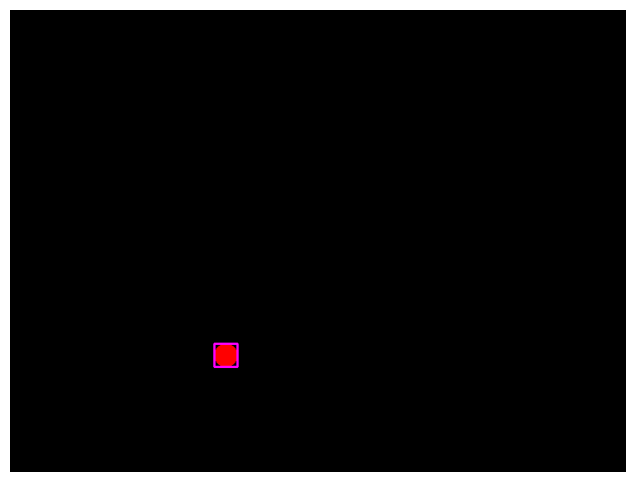

In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Set up the canvas
width, height = 800, 600
canvas = np.zeros((height, width, 3), dtype='uint8')

# Define the object (a red circle)
# Initial position
x = 0
# Radius
radius = 15
# Color (BGR format)
color = (0, 0, 255)  # Red

# Sine wave parameters
amplitude = 150
frequency = 0.05
y_center = height // 2

# Set up the plot for animation
plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots(figsize=(8, 6))

init_state_vector = np.array([0, y_center])
init_measurement_vector = np.array([0, y_center])
kalman_filter = KalmanFilter(init_state_vector, init_measurement_vector)
while True:
    # Create a blank canvas for the new frame
    canvas = np.zeros((height, width, 3), dtype='uint8')

    # Update the x position and wrap around the screen
    x += 2  # Adjust this value for speed
    if x > width:
        x = 0

    # Calculate the y position using a sine function
    y = int(amplitude * math.sin(frequency * x) + y_center)
    new_measurement = np.array([x, y])
    kalman_filter.predict()
    new_state = kalman_filter.update(new_measurement)

    # Draw the circle on the canvas
    cv2.circle(canvas, (x, y), radius, color, -1)
    new_x, new_y = int(new_state[0]), int(new_state[1])
    cv2.rectangle(canvas, (new_x-radius, new_y-radius), (new_x+radius, new_y+radius), (255, 0, 255), 2)
    # Convert the canvas to RGB for matplotlib
    rgb_canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

    # Display the frame in the notebook
    ax.clear()  # Clear the previous plot
    ax.imshow(rgb_canvas)
    ax.axis('off')  # Hide the axes
    
    # Update and clear the output for animation
    display(fig)
    clear_output(wait=True)
    
    # Pause for a short duration to control the speed
    time.sleep(0.01)

    # Note: There's no standard way to handle key presses in a while loop in a Jupyter Notebook.
    # To stop the loop, you typically manually interrupt the kernel.